In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist


from PIL import Image


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier


from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import hog
from skimage import exposure
from sklearn.preprocessing import MinMaxScaler
from joblib import dump, load
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn.metrics import accuracy_score, classification_report , confusion_matrix
import seaborn as sns


In [25]:
train_df = pd.read_csv("mnist_train.csv",header=None)
test_df = pd.read_csv("mnist_test.csv",header=None)
data = pd.concat([train_df, test_df])


train_labels = train_df.iloc[:, 0]
train_images = train_df.iloc[:, 1:].values  

test_labels = test_df.iloc[:, 0]
test_images = test_df.iloc[:, 1:].values  

images =data.iloc[:, 1:].values  
labels = data.iloc[:, 0]


In [26]:
# print(test_df)
print(images.shape)
print(labels.shape)
# print(train_images[69999])



(70000, 784)
(70000,)


# Phase1

## sobel filter


sobel_x:
$$
G_x=
\begin{bmatrix}
1 & 0 & -1 \\
2 & 0 & -2 \\
1 & 0 & -1 \\
\end{bmatrix} * A
$$

sobel_y:
$$
G_y =
\begin{bmatrix}
1 & 0 & -1 \\
2 & 0 & -2 \\
1 & 0 & -1 \\
\end{bmatrix} * A
$$


final sobel:
$$
G = \sqrt{G^2_x + G^2_y}
$$

In [29]:
raw_features = []
for i in range(len(images)):
  raw_feature = images[i].flatten()
  raw_features.append(raw_feature)



In [35]:
 # Sobel filter kernels
sobel_x = np.array([[ -1, 0, 1],
                    [ -2, 0, 2],
                    [ -1, 0, 1]])

sobel_y = np.array([[ 1,  2,  1],
                    [ 0,  0,  0],
                    [-1, -2, -1]])

sobelKernel = {"x": sobel_x , "y": sobel_y}


## convolution function

sobel convo

In [140]:

sobel_images = []
sobel_features = []
def convolve2d(image, kernel):

    image_array = np.asarray(image, dtype='int32')

    rows, cols = image_array.shape

    # Initialize gradient matrices
    grad_x = np.zeros((rows, cols))
    grad_y = np.zeros((rows, cols))
    grad_magnitude = np.zeros((rows, cols))

    # Apply convolution (excluding edges)
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            region = image_array[i-1:i+2, j-1:j+2]
            grad_x[i, j] = np.sum(region * kernel["x"])
            grad_y[i, j] = np.sum(region * kernel["y"])
            grad_magnitude[i, j] = np.sqrt(grad_x[i, j]**2 + grad_y[i, j]**2)

    grad_magnitude = (grad_magnitude / grad_magnitude.max() * 255).astype(np.uint8)
    sobel_feature = grad_magnitude.flatten()

    return grad_magnitude , sobel_feature




for i in range(len(images)):
 final_sobel, sobel_feature = convolve2d(images[i].reshape(28, 28),sobelKernel)
 sobel_images.append(final_sobel)
 sobel_features.append(sobel_feature)


HOG filter and extract features and concat with sobel features

In [141]:
sobel_features_copy = sobel_features.copy()
def extract_hog_features(image):
    features, hog_image = hog(image,
                               orientations=9,
                               pixels_per_cell=(4, 4),
                               cells_per_block=(2, 2),
                               visualize=True)

    return features, hog_image

def combine_features_batch(images, sobel_images_copy):
    combined_features_list = []
    hog_images_list = []

    for i, image in enumerate(images):
        hog_features, hog_image = extract_hog_features(image)
        combined_features = np.concatenate((sobel_images_copy[i].flatten(), hog_features))
        combined_features_list.append(combined_features)
        hog_images_list.append(hog_image)

    return np.array(combined_features_list), hog_images_list


tesssssssssssssst = []
for i in range(len(images)):
  tesssssssssssssst.append(images[i].reshape(28, 28))


combined_features_sobel_HOG, hog_images = combine_features_batch(tesssssssssssssst, sobel_features_copy)

In [142]:
print(f"Length of each combined feature vector: {len(combined_features_sobel_HOG[0])}")
print("Combined feature vector for the first image:", combined_features_sobel_HOG[0])

Length of each combined feature vector: 2080
Combined feature vector for the first image: [0. 0. 0. ... 0. 0. 0.]


### test a another kernel

In [143]:
sharpening_kernel = np.array([[0, -1, 0],
                              [-1, 5, -1],
                              [0, -1, 0]])

laplacian_kernel = np.array([[0, 1, 0],
                             [1, -4, 1],
                             [0, 1, 0]])


In [144]:
import numpy as np
import cv2

def apply_convolution(image, kernel):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=0)

    output_image = np.zeros_like(image)

    # Perform convolution
    for i in range(image_height):
        for j in range(image_width):
            # Extract the region of interest
            region = padded_image[i:i+kernel_height, j:j+kernel_width]
            # Element-wise multiplication and summing
            output_value = np.sum(region * kernel)
            # Store the result in the output image
            output_image[i, j] = np.clip(output_value, 0, 255)
    return output_image

sharpened_images = []
laplacian_images = []


for i in range(len(images)):
  print(i)
  sharpened_image = apply_convolution(images[i].reshape(28, 28), sharpening_kernel)
  laplacian_image = apply_convolution(images[i].reshape(28, 28), laplacian_kernel)
  sharpened_images.append(sharpened_image)
  laplacian_images.append(laplacian_image)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [145]:
def apply_laplacian(image):
    return apply_convolution(image, laplacian_kernel)

def apply_sharpening(image):
    return apply_convolution(image, sharpening_kernel)


def combine_features_laplacian_and_sharpening(image, i):
    hog_features, hog_image = extract_hog_features(image)

    combined_features_hog_with_laplacian = np.concatenate((laplacian_images[i].flatten(), hog_features))

    combined_features_hog_with_sharpening = np.concatenate((sharpened_images[i].flatten(), hog_features))

    return combined_features_hog_with_laplacian ,combined_features_hog_with_sharpening , hog_image

combined_features_hog_with_laplacians = []
combined_features_hog_with_sharpenings = []
for i in range(len(images)):
  combined_features_hog_with_laplacian,combined_features_hog_with_sharpening, hog_image_test = combine_features_laplacian_and_sharpening(images[i].reshape(28, 28), i)
  combined_features_hog_with_laplacians.append(combined_features_hog_with_laplacian)
  combined_features_hog_with_sharpenings.append(combined_features_hog_with_sharpening)


print(f"Combined feature vector length with Laplacian: {len(combined_features_hog_with_laplacian)}")


print(f"Combined feature vector length with sharpening: {len(combined_features_hog_with_sharpening)}")

Combined feature vector length with Laplacian: 2080
Combined feature vector length with sharpening: 2080


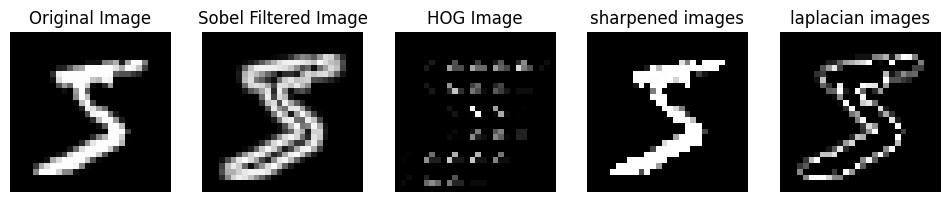

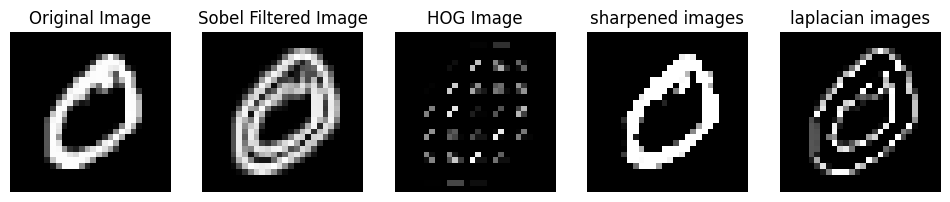

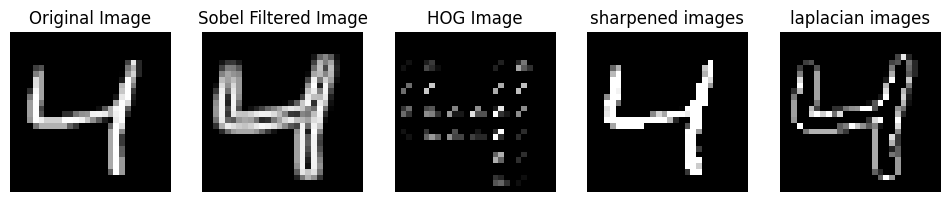

In [146]:
sobel_images
hog_images
sharpened_images
laplacian_images


# features ---> / raw data / sobel / sobel + HOG / laplacians + HOG / sharpenings + HOG
raw_features
sobel_features
combined_features_sobel_HOG
combined_features_hog_with_laplacians
combined_features_hog_with_sharpenings

for i in range(3):
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 5, 1)
    plt.title("Original Image")
    image = images[i].reshape(28, 28)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.title("Sobel Filtered Image")
    sobel_image=sobel_images[i]
    plt.imshow(sobel_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.title("HOG Image")
    hog_image=hog_images[i]
    plt.imshow(hog_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.title("sharpened images")
    sharpened_image=sharpened_images[i]
    plt.imshow(sharpened_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.title("laplacian images")
    laplacian_image=laplacian_images[i]
    plt.imshow(laplacian_image, cmap='gray')
    plt.axis('off')

    plt.show()




# Phase2

### Plotting Original Pictures

## فاز 2 فانشکنال

In [147]:
def process_Phase2(images,do_plot=True):
    mean_image = images.mean(axis=0)
    if do_plot:
        mean_image_shaped = mean_image.reshape(28, 28)
        plt.imshow(mean_image_shaped, cmap='gray')
        plt.title("Mean Image")
        plt.axis('off')
        plt.show()

    centered_images = images - mean_image
    if do_plot:
        plt.figure(figsize=(10, 5))
        for i in range(10): 
            image = centered_images[i].reshape(28, 28)  
            plt.subplot(2, 5, i + 1)
            plt.imshow(image, cmap='gray')
            plt.axis('off')
    
        plt.suptitle("Centered Images")
        plt.show()

    pca = PCA()
    pca.fit(centered_images)
    cumulative_variance = pca.explained_variance_ratio_.cumsum()

    plt.figure(figsize=(10, 6))
    # plt.plot(range(1, n_components + 1), cumulative_variance, marker='o')
    plt.plot(range(1, 101), cumulative_variance[:100], marker='o')  # Plot only the first 20 components
    plt.title("Cumulative Variance Explained by PCA Components")
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Variance Explained")
    plt.axhline(y=0.80, color='r', linestyle='--')  

    plt.grid()
    plt.show()

    best_n_components = np.argmax(cumulative_variance >= 0.80) + 1
    print(f"Number of components to explain at least 80% variance: {best_n_components}")

    return centered_images, mean_image, cumulative_variance, best_n_components



## raw data

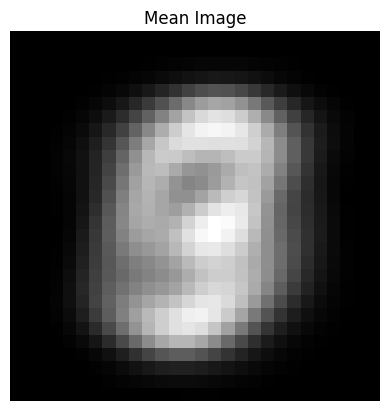

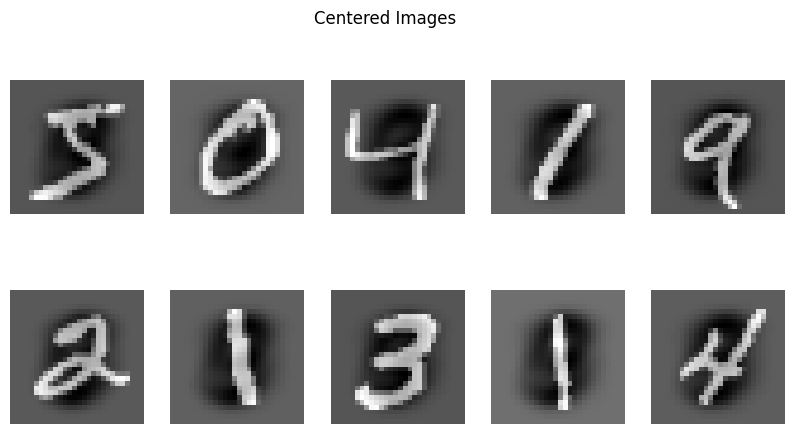

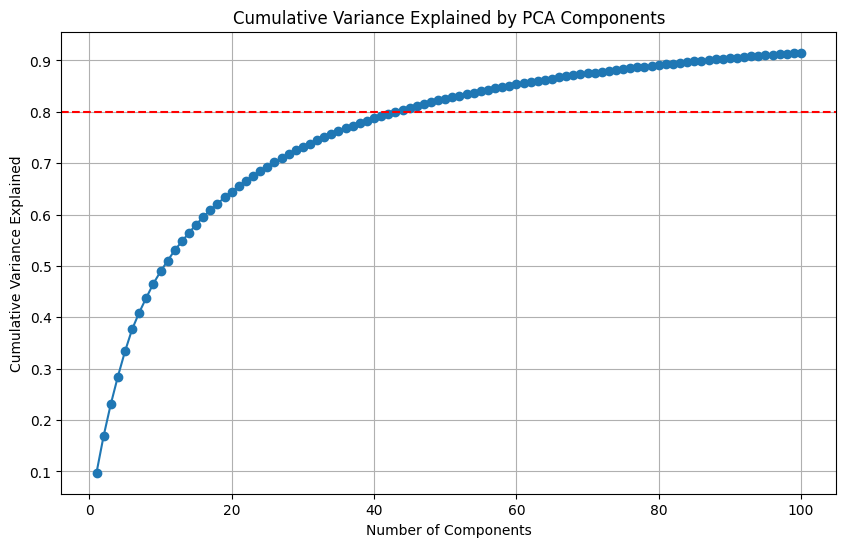

Number of components to explain at least 80% variance: 43


In [14]:
centered_images_raw,mean_image_raw,cumulative_variance_raw,best_n_components_raw=process_Phase2(images)


In [15]:
scaler = MinMaxScaler()
centered_images_raw_scaled = scaler.fit_transform(centered_images_raw)


pca = PCA(n_components=best_n_components_raw)
proccessed_raw = pca.fit_transform(centered_images_raw_scaled)

In [16]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(proccessed_raw, labels, test_size=0.2, random_state=42)


In [32]:
np.save('X_train_raw.npy', X_train_raw)
np.save('X_test_raw.npy', X_test_raw)
np.save('y_train_raw.npy', y_train_raw)
np.save('y_test_raw.npy', y_test_raw)


## Sobel + HOG FV

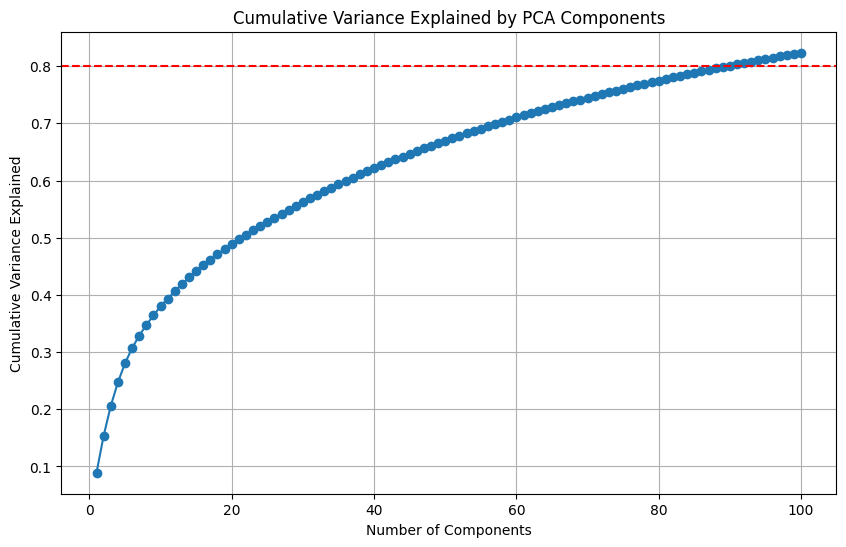

Number of components to explain at least 80% variance: 90


In [17]:
centered_FV_Sobel_HOG,mean_FV_Sobel_HOG,cumulative_variance_Sobel_HOG,best_n_components_Sobel_HOG=process_Phase2(combined_features_sobel_HOG,do_plot=False)


In [18]:
scaler = MinMaxScaler()
centered_FV_Sobel_HOG_scaled = scaler.fit_transform(centered_FV_Sobel_HOG)


pca = PCA(n_components=best_n_components_Sobel_HOG)
proccessed_Sobel_HOG= pca.fit_transform(centered_FV_Sobel_HOG)
proccessed_Sobel_HOG.shape

(70000, 90)

In [33]:
X_train_Sobel_HOG, X_test_Sobel_HOG, y_train_Sobel_HOG, y_test_Sobel_HOG = train_test_split(proccessed_Sobel_HOG, labels, test_size=0.2, random_state=42)
np.save('X_train_Sobel_HOG.npy', X_train_Sobel_HOG)
np.save('X_test_Sobel_HOG.npy', X_test_Sobel_HOG)
np.save('y_train_Sobel_HOG.npy', y_train_Sobel_HOG)
np.save('y_test_Sobel_HOG.npy', y_test_Sobel_HOG)


# Phase 3


In [ ]:
from sklearn.svm import SVC

best_svm_model = SVM_grid_search.best_estimator_
best_svm_model.fit(X_train, y_train)

# Test the model on the test data
y_pred_svm = best_svm_model.predict(X_test)

# Evaluate the performance
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print("SVM Test Accuracy: {:.2f}%".format(svm_accuracy * 100))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))


## DT فانکشنال


In [152]:
param_grid = {
    'criterion': ['gini', 'entropy'], 
    'min_samples_leaf': [1, 2, 5, 10],
    'max_depth': [None,5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 15]
}
param_grid_2 = {
    'criterion': ['gini', 'entropy'], 
    'min_samples_leaf': [1, 2, 5, 10],
    'max_depth': [None, 10, 20, 30,50,70],
    'min_samples_split': [2, 5, 10, 15]
}
param_grid_3 = {
    'criterion': ['gini', 'entropy'], 
    'min_samples_leaf': [1, 2, 5, 10],
    'max_depth': [None, 20, 50,300],
    'min_samples_split': [2, 5, 10, 15]
}
param_grid_4 = {
    'criterion': ['gini', 'entropy'], 
    'min_samples_leaf': [1, 2, 5, 10],
    'max_depth': [20, 100,200,500],
    'min_samples_split': [2, 5, 10, 15]
}
def grid_search_with_plot(X_train, y_train, param_grid=param_grid):
    model = DecisionTreeClassifier()

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5, 
        scoring='accuracy',
        n_jobs=5, 
        verbose=2
    )
 
    grid_search.fit(X_train, y_train)

    results = grid_search.cv_results_
    param_names = list(param_grid.keys())
    
    plt.figure(figsize=(15, 10))
    for i, param_name in enumerate(param_names):
        param_values = [params[param_name] for params in results['params']]
        mean_test_scores = results['mean_test_score']

        plt.subplot(2, 2, i + 1)  
        plt.scatter(param_values, mean_test_scores, c='blue', edgecolor='k', s=40)
        plt.plot(param_values, mean_test_scores, marker='o', color='green')
        plt.xlabel(param_name)
        plt.ylabel("Mean Test Score")
        plt.title(f"Grid Search Results for {param_name}")
        plt.grid()

    plt.tight_layout()
    plt.show()


    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
    
    return grid_search.best_estimator_, grid_search.best_params_



## raw_image_p2

Fitting 5 folds for each of 160 candidates, totalling 800 fits


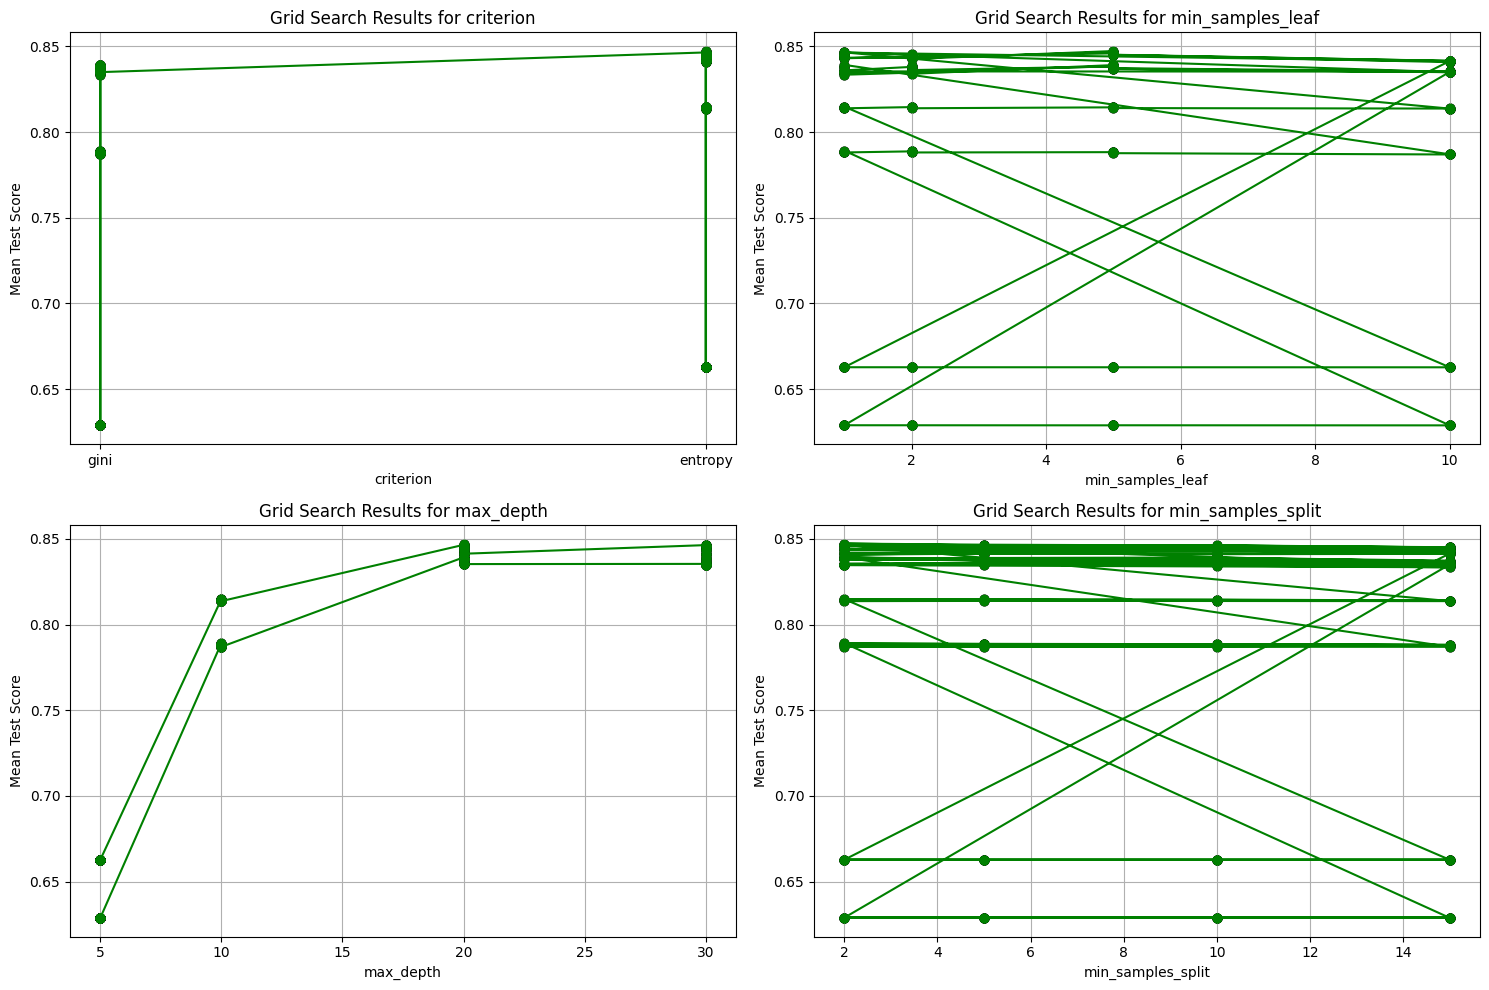

Best parameters found:  {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best cross-validation score: 0.85


['best_estimator_dt_raw.joblib']

In [45]:
best_estimator_raw,best_params_raw=grid_search_with_plot(X_train_raw,y_train_raw)
dump(best_estimator_raw, 'best_estimator_dt_raw.joblib')


## Sobel_HOG_FV_p2

Fitting 5 folds for each of 192 candidates, totalling 960 fits


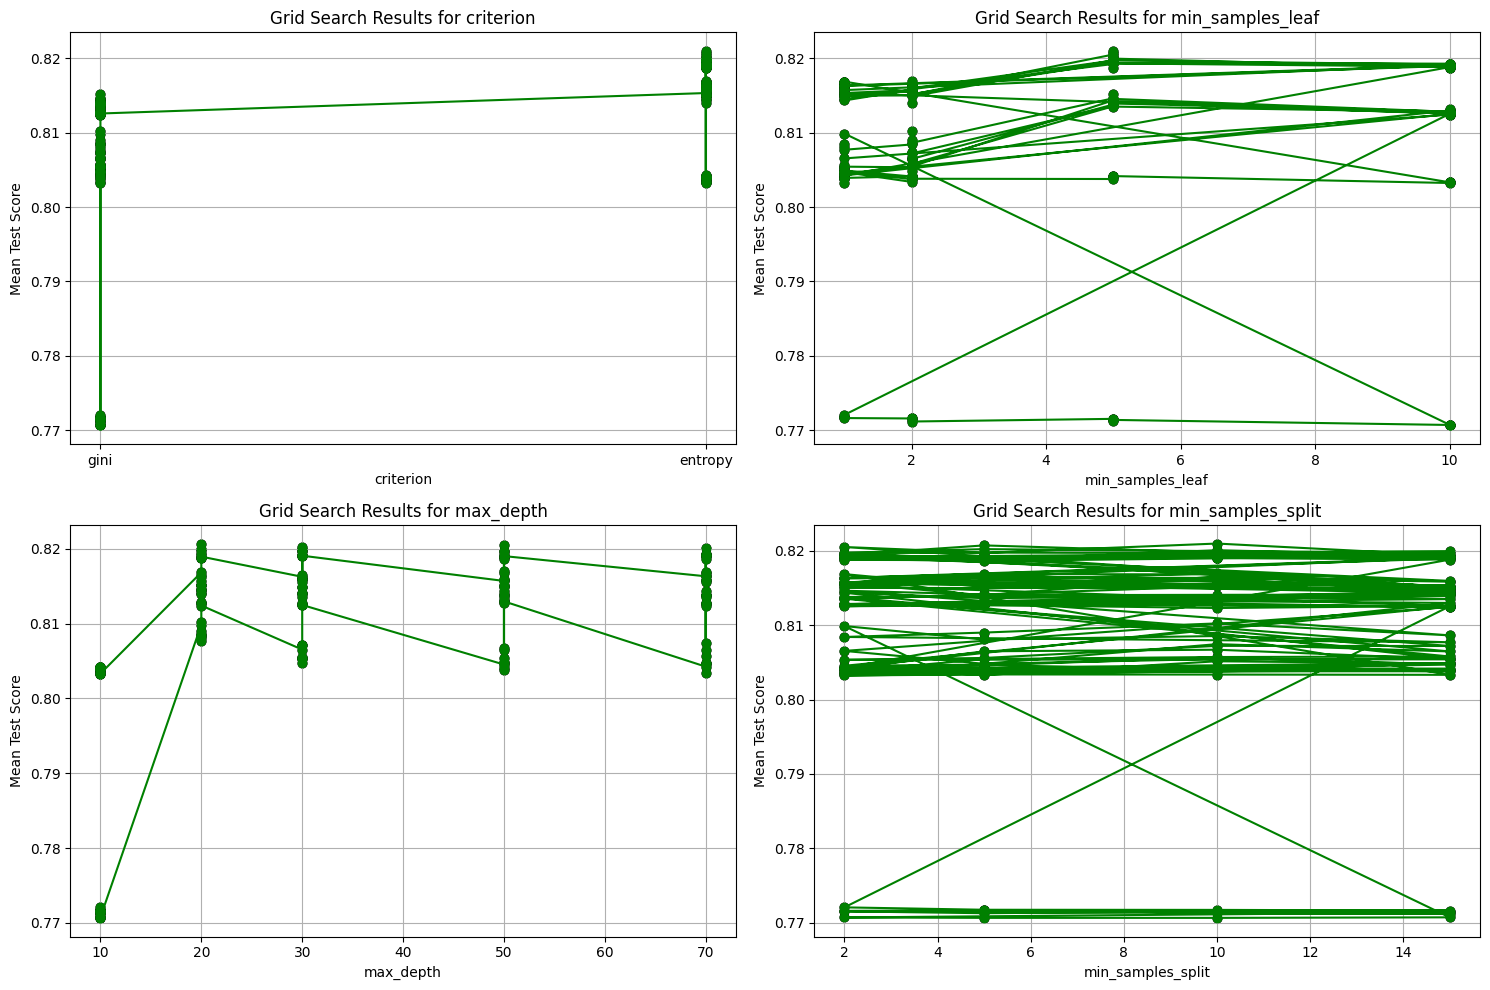

Best parameters found:  {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10}
Best cross-validation score: 0.82


['best_estimator_dt_Sobel_Hog.joblib']

In [46]:
best_estimator_Sobel_HOG,best_params_Sobel_HOG=grid_search_with_plot(X_train_Sobel_HOG,y_train_Sobel_HOG,param_grid=param_grid_2)
joblib.dump(best_estimator_Sobel_HOG, 'best_estimator_dt_Sobel_Hog.joblib')


## Sobel_image

In [158]:
sobel_flated= np.array(sobel_images)
sobel_flated=sobel_flated.reshape(70000, -1)
sobel_flated.shape

(70000, 784)

In [ ]:
scaler = MinMaxScaler()
image_Sobel_scaled = scaler.fit_transform(sobel_flated)


X_train_Sobel, X_test_Sobel, y_train_Sobel, y_test_Sobel = train_test_split(image_Sobel_scaled, labels, test_size=0.2, random_state=42)

best_estimator_Sobel,best_params_Sobel=grid_search_with_plot(X_train_Sobel,y_train_Sobel,param_grid=param_grid_3)
joblib.dump(best_estimator_Sobel, 'best_estimator_dt_Sobel.joblib')

In [160]:
X_train_Sobel, X_test_Sobel, y_train_Sobel, y_test_Sobel = train_test_split(image_Sobel_scaled, labels, test_size=0.2, random_state=42)

np.save('X_train_Sobel.npy', X_train_Sobel)
np.save('X_test_Sobel.npy', X_test_Sobel)
np.save('y_train_Sobel.npy', y_train_Sobel)
np.save('y_test_Sobel.npy', y_test_Sobel)


## HOG_filter_FV

In [148]:
HOG_filter_flated= np.array(combined_features_hog_with_laplacians)
HOG_filter_flated=HOG_filter_flated.reshape(70000, -1)
HOG_filter_flated.shape

(70000, 2080)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


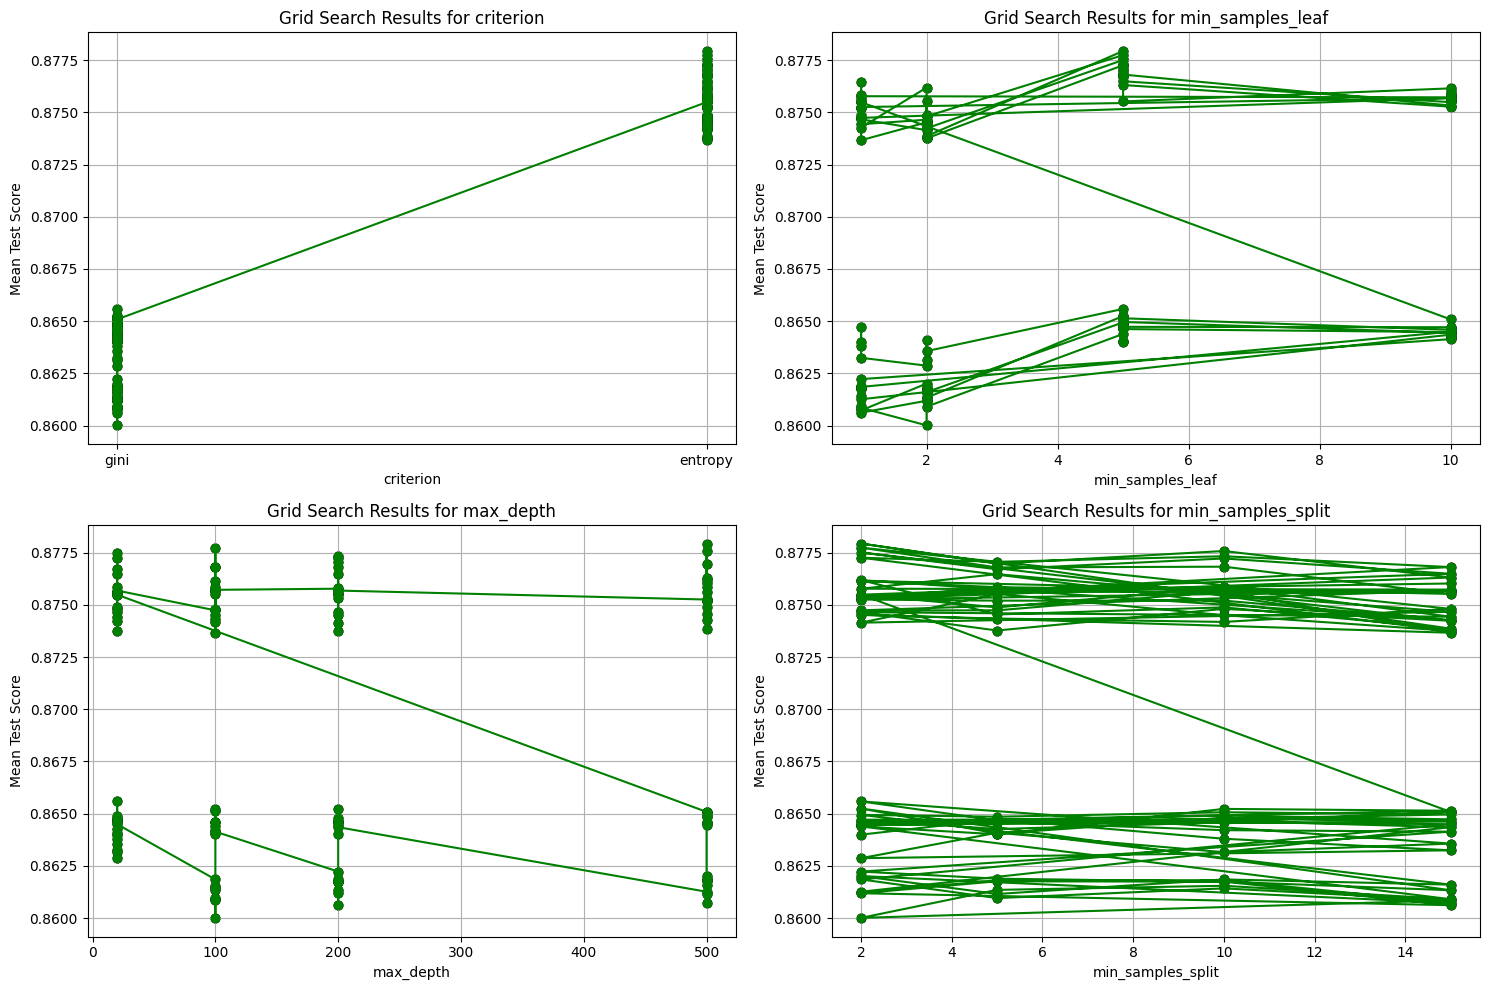

Best parameters found:  {'criterion': 'entropy', 'max_depth': 500, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best cross-validation score: 0.88


['best_estimator_dt_HOG_filter.joblib']

In [153]:
scaler = MinMaxScaler()
FV_HOG_Filter_scaled = scaler.fit_transform(HOG_filter_flated)


X_train_HOG_Filter, X_test_HOG_Filter, y_train_HOG_Filter, y_test_HOG_Filter = train_test_split(FV_HOG_Filter_scaled, labels, test_size=0.2, random_state=42)

best_estimator_HOG_Filter,best_params_HOG_Filter=grid_search_with_plot(X_train_HOG_Filter,y_train_HOG_Filter,param_grid=param_grid_4)
dump(best_estimator_HOG_Filter, 'best_estimator_dt_HOG_filter.joblib')

In [162]:
X_train_HOG_Filter, X_test_HOG_Filter, y_train_HOG_Filter, y_test_HOG_Filter = train_test_split(FV_HOG_Filter_scaled, labels, test_size=0.2, random_state=42)

np.save('X_train_HOG_Filter.npy', X_train_HOG_Filter)
np.save('X_test_HOG_Filter.npy', X_test_HOG_Filter)
np.save('y_train_HOG_Filter.npy', y_train_HOG_Filter)
np.save('y_test_HOG_Filter.npy', y_test_HOG_Filter)

## SVM

## Sobel_HOG

In [ ]:
# sobel_HOG_Best_SVM=apply_svm_with_tuning(X_train_Sobel_HOG,y_train_Sobel_HOG)
# dump(sobel_HOG_Best_SVM, 'sobel_HOG_Best_SVM.joblib')


Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [3]:
X_train_Sobel_HOG= np.load("Data/X_train_Sobel_HOG.npy")
y_train_Sobel_HOG= np.load("Data/y_train_Sobel_HOG.npy")

In [21]:
default_svm = SVC()
default_svm.fit(X_train_Sobel_HOG, y_train_Sobel_HOG)
dump(default_svm, 'default_svm.joblib')


['default_svm.joblib']

In [20]:
C_svm = SVC(C=10)
C_svm.fit(X_train_Sobel_HOG, y_train_Sobel_HOG)
dump(C_svm, 'C_svm.joblib')


['C_svm.joblib']

In [21]:
C2_svm = SVC(C=0.1)
C2_svm.fit(X_train_Sobel_HOG, y_train_Sobel_HOG)
dump(C2_svm, 'C2_svm.joblib')


['C2_svm.joblib']

In [4]:
gamma_svm = SVC(gamma='auto')
gamma_svm.fit(X_train_Sobel_HOG, y_train_Sobel_HOG)
dump(gamma_svm, 'gamma_svm.joblib')


['gamma_svm.joblib']

In [5]:
gamma2_svm = SVC(gamma=.01)
gamma2_svm.fit(X_train_Sobel_HOG, y_train_Sobel_HOG)
dump(gamma2_svm, 'gamma2_svm.joblib')


['gamma2_svm.joblib']

## raw

In [25]:
default_svm_raw = SVC()
default_svm_raw .fit(X_train_raw, y_train_raw)
dump(default_svm_raw, 'default_svm_raw.joblib')

['default_svm_raw.joblib']

In [27]:
C_svm_raw  = SVC(C=10)
C_svm_raw .fit(X_train_raw, y_train_raw)
dump(C_svm_raw, 'C_svm_raw.joblib')

['C_svm_raw.joblib']

In [28]:
C2_svm_raw  = SVC(C=.1)
C2_svm_raw .fit(X_train_raw, y_train_raw)
dump(C2_svm_raw, 'C2_svm_raw.joblib')

['C2_svm_raw.joblib']

In [29]:
gamma_svm_raw  = SVC(gamma='auto')
gamma_svm_raw .fit(X_train_raw, y_train_raw)
dump(gamma_svm_raw, 'gamma_svm_raw.joblib')

['gamma_svm_raw.joblib']

In [30]:
gamma2_svm_raw  = SVC(gamma=.01)
gamma2_svm_raw .fit(X_train_raw, y_train_raw)
dump(gamma2_svm_raw, 'gamma2_svm_raw.joblib')

['gamma2_svm_raw.joblib']

In [31]:
type(X_test_raw)

numpy.ndarray

## Visualize tree

In [90]:
model=load("DT/best_estimator_dt_HOG_filter.joblib")

In [91]:
model

DecisionTreeClassifier(criterion='entropy', max_depth=100, min_samples_leaf=5,
                       min_samples_split=10)

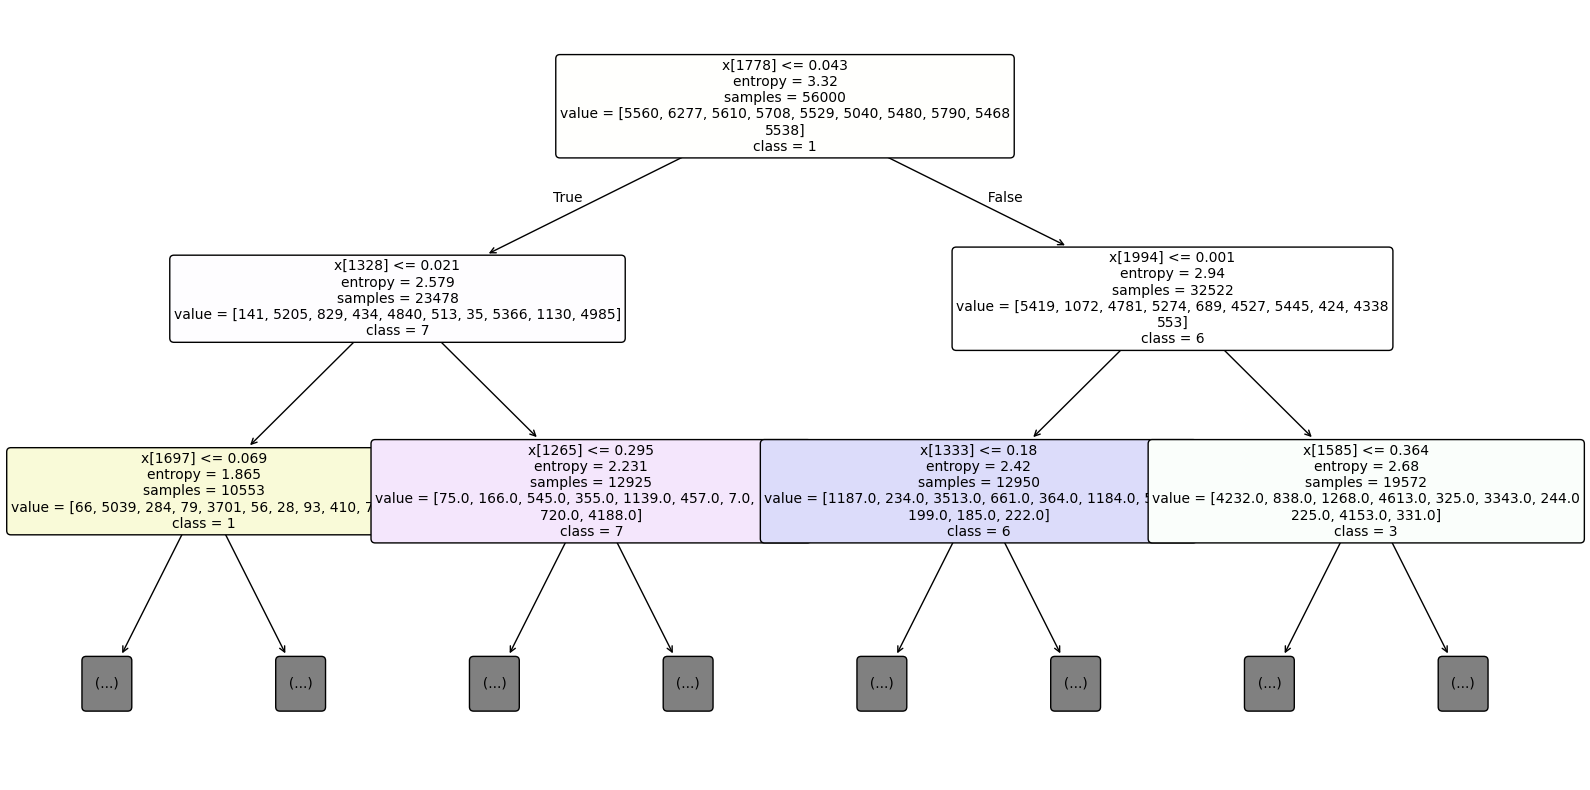

In [150]:
plt.figure(figsize=(20, 10))  
plot_tree(
    model, 
    feature_names=X_train_HOG_Filter.columns if hasattr(X_train_HOG_Filter, 'columns') else None,  # Feature names
    class_names=[str(cls) for cls in overfitted_model.classes_], 
    filled=True, 
    rounded=True,  
    fontsize=10,  
    max_depth=2,
  label='all'
)
plt.show()

# Phase 4

In [164]:
X_test_raw = np.load('data/X_test_raw.npy')
y_test_raw = np.load('data/y_test_raw.npy')
y_test_Sobel_HOG = np.load('data/y_test_Sobel_HOG.npy')
X_test_Sobel_HOG = np.load('data/X_test_Sobel_HOG.npy')
X_test_sobel = np.load('data/X_test_sobel.npy')
y_test_sobel = np.load('data/y_test_sobel.npy')
# X_test_hog_with_laplacians = np.load('data/X_test_hog_with_laplacians.npy')
# y_test_hog_with_laplacians = np.load('data/y_test_hog_with_laplacians.npy')


In [165]:
ddd = type(y_test_raw)
print(ddd)
y_test_sobel[1]

<class 'numpy.ndarray'>


4

In [168]:


# X_train_raw, X_test_raw, y_train_raw, y_test_raw 

import joblib

file_path = 'DT/best_estimator_dt_raw.joblib'
model = joblib.load(file_path)


result_raw_DT = model.predict(X_test_raw)

print('predict array: ',result_raw_DT)

test =  accuracy_score(y_test_raw,result_raw_DT)
test2 =classification_report(y_test_raw,result_raw_DT)
print(" \naccuracy_score: ", test )
print(" \nclassification_report: \n" , test2)


predict array:  [8 7 8 ... 2 7 1]
 
accuracy_score:  0.8536428571428571
 
classification_report: 
               precision    recall  f1-score   support

           0       0.90      0.90      0.90      1343
           1       0.95      0.97      0.96      1600
           2       0.83      0.85      0.84      1380
           3       0.80      0.82      0.81      1433
           4       0.81      0.83      0.82      1295
           5       0.80      0.80      0.80      1273
           6       0.90      0.92      0.91      1396
           7       0.90      0.87      0.88      1503
           8       0.82      0.77      0.79      1357
           9       0.79      0.78      0.79      1420

    accuracy                           0.85     14000
   macro avg       0.85      0.85      0.85     14000
weighted avg       0.85      0.85      0.85     14000



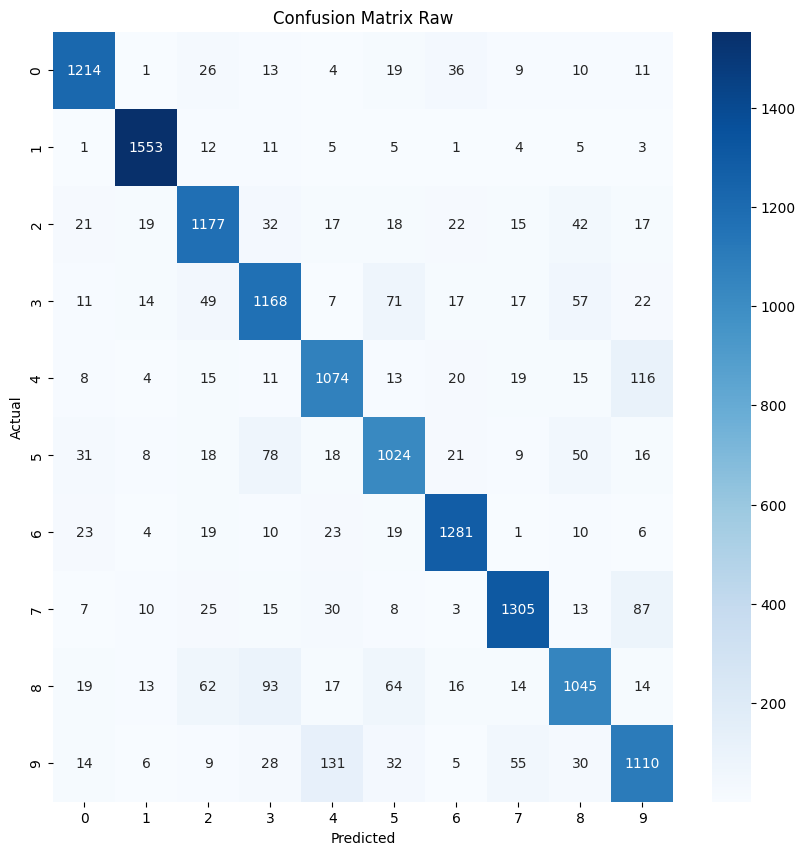

In [173]:
# محاسبه ماتریس سردرگمی
cm = confusion_matrix(y_test_raw,result_raw_DT)
# Visualize کردن ماتریس به صورت Heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels="0123456789", yticklabels="0123456789")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Raw')
plt.show()

In [ ]:
import joblib
# data
# X_train_Sobel_HOG, X_test_Sobel_HOG, y_train_Sobel_HOG, y_test_Sobel_HOG 
loaded_model = joblib.load('models/best_estimator_dt_Sobel_Hog.joblib')
result_Sobel_HOG_DT = loaded_model.predict(X_test_Sobel_HOG)
print('predict array: ',result_Sobel_HOG_DT)

test =  accuracy_score(y_test_Sobel_HOG,result_Sobel_HOG_DT)
test2 =classification_report(y_test_Sobel_HOG,result_Sobel_HOG_DT)
print(" \naccuracy_score: ", test )
print(" \nclassification_report: \n" , test2)

In [ ]:
# محاسبه ماتریس سردرگمی
cm = confusion_matrix(y_test_Sobel_HOG,result_Sobel_HOG_DT)
# Visualize کردن ماتریس به صورت Heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels="0123456789", yticklabels="0123456789")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Sobel + HOG')
plt.show()

In [ ]:

# data
# X_train_Sobel_HOG, X_test_Sobel_HOG, y_train_Sobel_HOG, y_test_Sobel_HOG 
loaded_model = joblib.load('models/best_estimator_dt_Sobel.joblib')
result_Sobel_DT = loaded_model.predict(X_test_sobel)
print('predict array: ',result_Sobel_DT)

test =  accuracy_score(y_test_sobel,result_Sobel_DT)
test2 =classification_report(y_test_sobel, result_Sobel_DT)
print(" \naccuracy_score: ", test )
print(" \nclassification_report: \n" , test2)

In [ ]:
# محاسبه ماتریس سردرگمی
cm = confusion_matrix(y_test_sobel,result_Sobel_DT)
# Visualize کردن ماتریس به صورت Heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels="0123456789", yticklabels="0123456789")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Sobel')
plt.show()

In [ ]:
loaded_model = joblib.load('models/best_estimator_dt_HOG_filter.joblib')
resulte_hog_with_laplacians_DT = loaded_model.predict(X_test_hog_with_laplacians)
print('predict array: ',resulte_hog_with_laplacians_DT)

test =  accuracy_score(y_test_hog_with_laplacians,resulte_hog_with_laplacians_DT)
test2 =classification_report(y_test_hog_with_laplacians, resulte_hog_with_laplacians_DT)
print(" \naccuracy_score: ", test )
print(" \nclassification_report: \n" , test2)

In [ ]:
# محاسبه ماتریس سردرگمی
cm = confusion_matrix(y_test_hog_with_laplacians,resulte_hog_with_laplacians_DT)
# Visualize کردن ماتریس به صورت Heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels="0123456789", yticklabels="0123456789")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix HOG with Laplacians')
plt.show()

In [ ]:

loaded_model = joblib.load('models/C_svm_raw.joblib')
result4 = loaded_model.predict(X_test_raw)
print(result4)

In [ ]:
test =  accuracy_score(y_test_raw,result4)
test2 =classification_report(y_test_raw,result4)
print(test)

In [ ]:
# محاسبه ماتریس سردرگمی
cm = confusion_matrix(y_test_raw,result4)
# Visualize کردن ماتریس به صورت Heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels="0123456789", yticklabels="0123456789")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix HOG with Laplacians')
plt.show()

In [ ]:
loaded_model = joblib.load('models/C2_svm_raw.joblib')
result5 = loaded_model.predict(X_test_raw)
print(result5)

In [ ]:
test =  accuracy_score(y_test_raw,result5)
test2 =classification_report(y_test_raw,result5)
print(test)

In [ ]:
# محاسبه ماتریس سردرگمی
cm = confusion_matrix(y_test_raw,result5)
# Visualize کردن ماتریس به صورت Heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels="0123456789", yticklabels="0123456789")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix HOG with Laplacians')
plt.show()

In [ ]:
loaded_model = joblib.load('models/default_svm_raw.joblib')
result6 = loaded_model.predict(X_test_raw)
print(result6)

In [ ]:
test =  accuracy_score(y_test_raw,result6)
test2 =classification_report(y_test_raw,result6)
print(test)

In [ ]:
# محاسبه ماتریس سردرگمی
cm = confusion_matrix(y_test_raw,result6)
# Visualize کردن ماتریس به صورت Heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels="0123456789", yticklabels="0123456789")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix HOG with Laplacians')
plt.show()

In [ ]:

loaded_model = joblib.load('models/gamma_svm_raw.joblib')
result12 = loaded_model.predict(X_test_raw)
print(result12)

In [ ]:
test =  accuracy_score(y_test_raw,result12)
test2 =classification_report(y_test_raw,result12)
print(test)

In [ ]:
# محاسبه ماتریس سردرگمی
cm = confusion_matrix(y_test_raw,result12)
# Visualize کردن ماتریس به صورت Heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels="0123456789", yticklabels="0123456789")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix HOG with Laplacians')
plt.show()

In [ ]:

loaded_model = joblib.load('models/gamma2_svm_raw.joblib')
result7 = loaded_model.predict(X_test_raw)
print(result7)

In [ ]:
test =  accuracy_score(y_test_raw,result7)
test2 =classification_report(y_test_raw,result7)
print(test)

In [ ]:
# محاسبه ماتریس سردرگمی
cm = confusion_matrix(y_test_raw,result7)
# Visualize کردن ماتریس به صورت Heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels="0123456789", yticklabels="0123456789")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix HOG with Laplacians')
plt.show()

In [ ]:

loaded_model = joblib.load('models/C_svm.joblib')
result9 = loaded_model.predict(X_test_Sobel_HOG)
print(result9)

In [ ]:
test =  accuracy_score(y_test_Sobel_HOG,result9)
test2 =classification_report(y_test_Sobel_HOG,result9)
print(test)

In [ ]:
# محاسبه ماتریس سردرگمی
cm = confusion_matrix(y_test_Sobel_HOG,result9)
# Visualize کردن ماتریس به صورت Heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels="0123456789", yticklabels="0123456789")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix HOG with Laplacians')
plt.show()

In [ ]:
loaded_model = joblib.load('models/C2_svm.joblib')
result10 = loaded_model.predict(X_test_Sobel_HOG)
print(result10)

# Phase 5


In [16]:
X_test_Sobel_HOG=np.load("Data/X_test_Sobel_HOG.npy")
X_train_Sobel_HOG =np.load("Data/X_train_Sobel_HOG.npy")
y_train_Sobel_HOG=np.load("Data/y_train_Sobel_HOG.npy")
y_test_Sobel_HOG= np.load("Data/y_test_Sobel_HOG.npy")
best_model=load("DT/best_estimator_dt_Sobel_Hog.joblib")

Best parameters found:  {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10}

In [69]:
overfitted_model = DecisionTreeClassifier(
    criterion="entropy",      
    max_depth=5,            
    min_samples_split=10,    
    min_samples_leaf=5,     
)


In [80]:
max_depth_range = [5, 10, 15,None]
min_samples_split_range = [2, 5, 20,10]
min_samples_leaf_range = [1, 10, 20,5]
results = []
for max_depth in max_depth_range:
    for min_samples_split in min_samples_split_range:
        for min_samples_leaf in min_samples_leaf_range:
          
            model = DecisionTreeClassifier(
                criterion="entropy",
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=42
            )
            model.fit(X_train_Sobel_HOG, y_train_Sobel_HOG)
            
            train_accuracy = accuracy_score(y_train_Sobel_HOG, model.predict(X_train_Sobel_HOG))
            test_accuracy = accuracy_score(y_test_Sobel_HOG, model.predict(X_test_Sobel_HOG))
            
            results.append({
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'train_accuracy': train_accuracy,
                'test_accuracy': test_accuracy
            })
results_df=pd.DataFrame(results)            

In [103]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
results_df = results_df[results_df['max_depth'] != 5]

results_df.sort_values(by="train_accuracy",ascending=False)


TypeError: 'Styler' object is not subscriptable

In [15]:
X_test_Sobel_HOG.shape

(14000, 90)

In [133]:
# Highlight rows by index
def highlight_by_index(row):
    if row.name in [48]:
        return ['background-color: red'] * len(row)
    elif row.name in [63]:
        return ['background-color: green'] * len(row)
    elif row.name in [60, 32, 52, 36, 44,42,58]:
        return ['background-color: yellow'] * len(row)
    else:
        return [''] * len(row)

styled_df = results_df.sort_values(by="train_accuracy",ascending=False).style.apply(highlight_by_index, axis=1)


In [134]:
styled_df
# Drop rows by index
# indices_to_drop = [55, 51, 47, 39, 35, 56, 40,43,49,53]
# results_df = results_df.drop(indices_to_drop)


,max_depth,min_samples_split,min_samples_leaf,train_accuracy,test_accuracy
48,nan,2,1,1.000000,0.821643
32,15.000000,2,1,0.987071,0.824143
52,nan,5,1,0.983518,0.821643
36,15.000000,5,1,0.974161,0.824786
60,nan,10,1,0.961911,0.819929
44,15.000000,10,1,0.955429,0.821857
63,nan,10,5,0.940661,0.823286
59,nan,20,5,0.917357,0.824714
61,nan,10,10,0.904804,0.828643
57,nan,20,10,0.904804,0.828643
